In [12]:
from src import flops_in_folder
from src import model_train_plot
from src import exponential_moving_average
import json
import numpy as np
import matplotlib.pyplot as plt

### Overall Flops in this Notebook:

In [13]:
_, _, _ = flops_in_folder('results/Initial_Lora')

Number of unique result files: 2
Total Training FLOPs: 6.159e+15
Total Evaluation FLOPs: 4.498e+14
Total Combined FLOPs: 6.609e+15
Percentage of Total FLOPs Budget:   6.6085 %


# Training
## Both training and hyperparameter tuning was using by submitting jobs to the HPC which returned json files of metrics
- The results of all tests are stored within the `results` diretory


# Investigating ability to train  (not neccesarily generalise):

- Attempt to Overfit Small data (a single trajectory)
- **learn_rate = 1e-3** (note this is not the default used but it run to show it can work)
- **lora_rank_tune = 4**

- To ensure that the training pipeline is valid, I attempt to overfit on a single training sequence and moniter the training preformance
- In this case the evaluation metric is not important as we are deliberatly overfitting on 2 sequences to ensure training is possible and valid using the base parameters

In [14]:
with open("results/Initial_Lora/Overfit_Train.json", "r") as f:
    results = json.load(f)

# Access the values
train_loss_tracker = results["train_loss_tracker"]    
train_step_tracker = results["train_step_tracker"] 
final_train_loss = train_loss_tracker[-1]
val_loss_final = results["val_loss_final"]

train_loss_tracker = np.array(train_loss_tracker)
train_step_tracker = np.array(train_step_tracker)

In [15]:
# Print metrics
print("Final Train Loss: ", final_train_loss)
print("Final Validation Loss: ", val_loss_final)

Final Train Loss:  0.1828635334968567
Final Validation Loss:  1.519472241997719


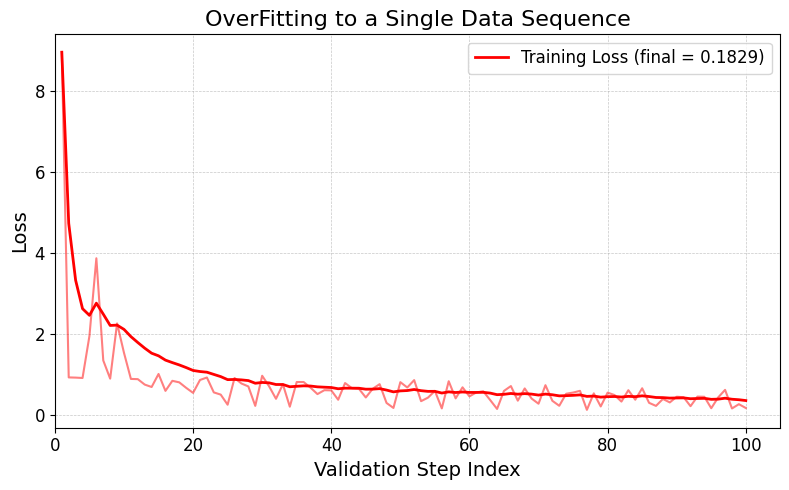

In [ ]:
plt.figure(figsize=(8, 5))

# ---- Training Plot (Raw + Time AvSmoothed) ----
plt.plot(train_step_tracker, train_loss_tracker, color='red', alpha=0.5)
smoothed_train = exponential_moving_average(train_loss_tracker, 0.9)
plt.plot(train_step_tracker, smoothed_train, color='red', linewidth=2, label=f'Training Loss (final = {final_train_loss:.4f})')

# Titles and labels
plt.title("OverFitting to a Single Data Sequence", fontsize=16)
plt.xlabel("Validation Step Index", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(left=0)
plt.xscale('linear')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


# Benchmark - Default Hyperparameters


- In this we aim to test the models ability to learn the full data set and generalise learning across many examples.
- This is run with early stopping with a patience of 3 to ensure that no extra compute is used than needed.
- We use the default hyperparameters given and this result is used within the hyperparameter search
- **learn_rate_tune = 1e-5**
- **lora_rank_tune = 4**


## Terms Explained
- **eval_freq** - this tells the evaluate its preformance ever 25 steps - with unlimited compute this would be more often
- **subset** - this says to evalaute it on 25 random samples from the validation set every time - with ulimited compute this would be higher
    - when evaluating at the end it uses 100 random examples

In [17]:
with open("results/Initial_Lora/Default_Values.json", "r") as f:
    results = json.load(f)

# Access the values
train_loss_tracker = results["train_loss_tracker"]    
train_step_tracker = results["train_step_tracker"] 
val_loss_tracker = results["val_loss_tracker"]
val_step_tracker = results["val_step_tracker"]
training_flops_base = results["training_flops"]
total_eval_cost_base = results["total_eval_cost"]
final_train_loss = train_loss_tracker[-1]
val_loss_final = results["val_loss_final"]
early_stopping_step = results["early_stopping_step"]

train_loss_tracker = np.array(train_loss_tracker)
train_step_tracker = np.array(train_step_tracker)


In [18]:
# Print metrics
print("Final Train Loss: ", final_train_loss)
print("Final Validation Loss: ", val_loss_final)
print(f"Total Training FLOPS: {training_flops_base:.3e}")
print(f"Total Evaluation Cost: {total_eval_cost_base:.3e}")

Final Train Loss:  0.9435019493103027
Final Validation Loss:  0.9293942031264305
Total Training FLOPS: 5.796e+15
Total Evaluation Cost: 3.593e+14


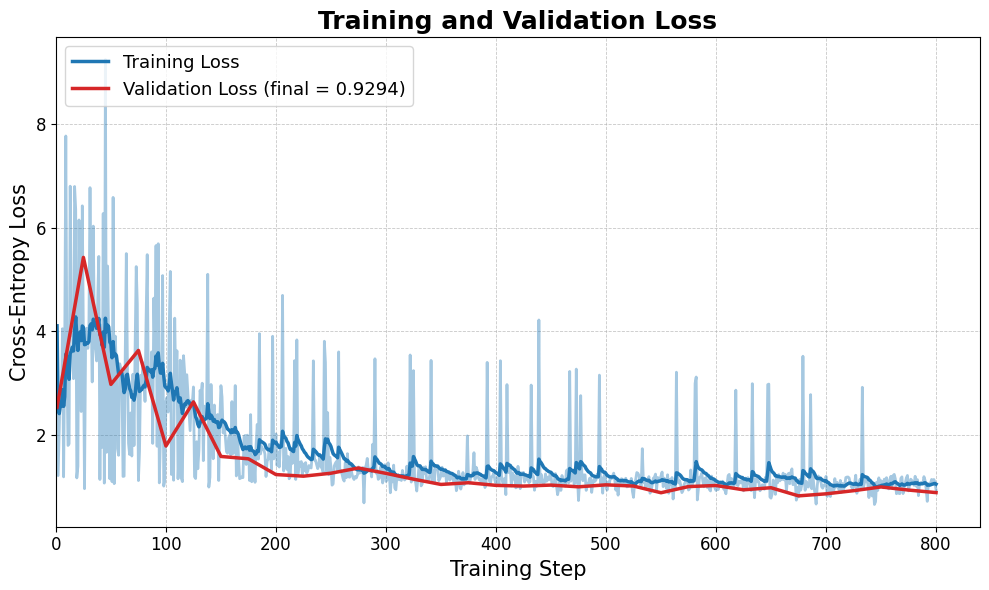

In [19]:
model_train_plot(train_step_tracker, train_loss_tracker, val_step_tracker, val_loss_tracker, val_loss_final, early_stopping_step)